## Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="ticks", font_scale=1.5)
import urllib.request
from scipy.stats import genextreme
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from scipy.optimize import curve_fit
import pyet
from noaa_ftp import NOAA
import folium
from sklearn.linear_model import LinearRegression


## Download data and make data frames

### For Precipitation Analysis

In [2]:
def download_data(station_name, station_code):
    url_daily = 'https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/'
    url_monthly = 'https://www.ncei.noaa.gov/data/gsom/access/'
    # download daily data - uncomment the following 2 lines to make this work
    urllib.request.urlretrieve(url_daily + station_code + '.csv',
                              station_name + '_daily.csv')
    # download monthly data
    urllib.request.urlretrieve(url_monthly + station_code + '.csv',
                               station_name + '_monthly.csv')

In [3]:
download_data('Utqiagvik', 'USW00027502')

In [4]:
df = pd.read_csv('Utqiagvik_daily.csv', sep=",")
# make 'DATE' the dataframe index
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')
# IMPORTANT!! daily precipitation, snow and snow depth data is in tenths of mm, divide by 10 to get it in mm.
df['PRCP'] = df['PRCP'] / 10
df['SNOW'] = df['SNOW'] / 10
df['SNWD'] = df['SNWD'] / 10
#remove the data until 1921, as it is incomplete
df = df.loc['1921':'2023']

C:\Users\gilif\AppData\Local\Temp\ipykernel_25204\1394075170.py:1: DtypeWarning: Columns (17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53,55,57,59,61,63,65,69,71,73,75,77,79,83,85,87,89,91,93,95,97,99,101,103,105,107) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Utqiagvik_daily.csv', sep=",")


### For Temperature Analysis

In [5]:
df_for_temp = pd.read_csv('Utqiagvik_monthly.csv', sep=",")
df_temp = pd.DataFrame()
df_temp['DATE'] = pd.to_datetime(df_for_temp['DATE'])
df_temp['TMIN'] = df_for_temp['TMIN']
df_temp['TMAX'] = df_for_temp['TMAX']
df_temp['TAVG'] = (df_temp['TMIN'] + df_temp['TMAX']) / 2
df_temp = df_temp.set_index('DATE')
#lets start from 1925 because 1924 value is unlikely
df_temp = df_temp.loc['1925':'2023']
df_aug = pd.DataFrame()
df_aug = df_temp.copy()
df_temp = df_temp['TAVG'].resample('Y').mean()
df_aug = df_aug.loc[df_aug.index.month == 8]

### For Evapotranspiration Analysis

In [6]:
#download the data from the NOAA ftp server
noaa = NOAA("ftp.ncdc.noaa.gov", 'pub/data/uscrn/products/subhourly01').download('HEADERS.txt')
noaa = NOAA("ftp.ncdc.noaa.gov", 'pub/data/uscrn/products/subhourly01/2019').download('CRNS0101-05-2019-AK_Utqiagvik_formerly_Barrow_4_ENE.txt')
noaa = NOAA("ftp.ncdc.noaa.gov", 'pub/data/uscrn/products/subhourly01/2020').download('CRNS0101-05-2020-AK_Utqiagvik_formerly_Barrow_4_ENE.txt')
noaa = NOAA("ftp.ncdc.noaa.gov", 'pub/data/uscrn/products/subhourly01/2021').download('CRNS0101-05-2021-AK_Utqiagvik_formerly_Barrow_4_ENE.txt')
noaa = NOAA("ftp.ncdc.noaa.gov", 'pub/data/uscrn/products/subhourly01/2022').download('CRNS0101-05-2022-AK_Utqiagvik_formerly_Barrow_4_ENE.txt')
noaa = NOAA("ftp.ncdc.noaa.gov", 'pub/data/uscrn/products/subhourly01/2023').download('CRNS0101-05-2023-AK_Utqiagvik_formerly_Barrow_4_ENE.txt')
noaa = NOAA("ftp.ncdc.noaa.gov", 'pub/data/uscrn/products/subhourly01/2018').download('CRNS0101-05-2018-AK_Utqiagvik_formerly_Barrow_4_ENE.txt')
noaa = NOAA("ftp.ncdc.noaa.gov", 'pub/data/uscrn/products/subhourly01/2017').download('CRNS0101-05-2017-AK_Utqiagvik_formerly_Barrow_4_ENE.txt')

Downloading:   0% [                                  ] ETA:  --:--:--   0.0 s/B
Downloading: 100% [##################################] ETA:  00:00:00 569.4 B/s
Downloading:   0% [                                  ] ETA:  --:--:--   0.0 s/B
Downloading:   0% [                                ] ETA:   0:26:28   8.7 KiB/s
Downloading:   0% [                                ] ETA:   0:11:34  19.9 KiB/s
Downloading:   0% [                                ] ETA:   0:06:43  34.2 KiB/s
Downloading:   0% [                                ] ETA:   0:03:38  62.8 KiB/s
Downloading:   1% [                                ] ETA:   0:01:53 120.4 KiB/s
Downloading:   2% [                                ] ETA:   0:01:17 175.5 KiB/s
Downloading:   3% [#                               ] ETA:   0:01:00 221.3 KiB/s
Downloading:   3% [#                               ] ETA:   0:00:55 240.7 KiB/s
Downloading:   4% [#                               ] ETA:   0:00:47 280.6 KiB/s
Downloading:   5% [#                    

In [7]:
#convert the data to a data frames
column_names = pd.read_csv('HEADERS.txt',
                        header=None,
                        sep='\s+',
                        )
#lets make a function that make data frame from a file
def read_noaa(file):

    df = pd.read_csv(file,  # file to read
                 sep='\s+',  # use (any number of) white spaces as delimiter between columns
                 names=column_names.iloc[1],  # column names from row i=1 of "column_names"
                 na_values=[-99, -9999, -99999],  # substitute these values by NaN
                 )
    df['LST_DATE'] = df['LST_DATE'].astype(str)#.apply(lambda x: f'{x:0>4}')
    df['LST_TIME'] = df['LST_TIME'].apply(lambda x: f'{x:0>4}')
    df['datetime'] = pd.to_datetime(df['LST_DATE'] + df['LST_TIME'], format='%Y%m%d%H%M')
    df = df.set_index('datetime')
    return df

df17 = read_noaa('CRNS0101-05-2017-AK_Utqiagvik_formerly_Barrow_4_ENE.txt')
df18 = read_noaa('CRNS0101-05-2018-AK_Utqiagvik_formerly_Barrow_4_ENE.txt')
df19 = read_noaa('CRNS0101-05-2019-AK_Utqiagvik_formerly_Barrow_4_ENE.txt')
df20 = read_noaa('CRNS0101-05-2020-AK_Utqiagvik_formerly_Barrow_4_ENE.txt')
df21 = read_noaa('CRNS0101-05-2021-AK_Utqiagvik_formerly_Barrow_4_ENE.txt')
df22 = read_noaa('CRNS0101-05-2022-AK_Utqiagvik_formerly_Barrow_4_ENE.txt')
df23 = read_noaa('CRNS0101-05-2023-AK_Utqiagvik_formerly_Barrow_4_ENE.txt')

# Temperature Analysis

<Figure size 800x500 with 0 Axes>

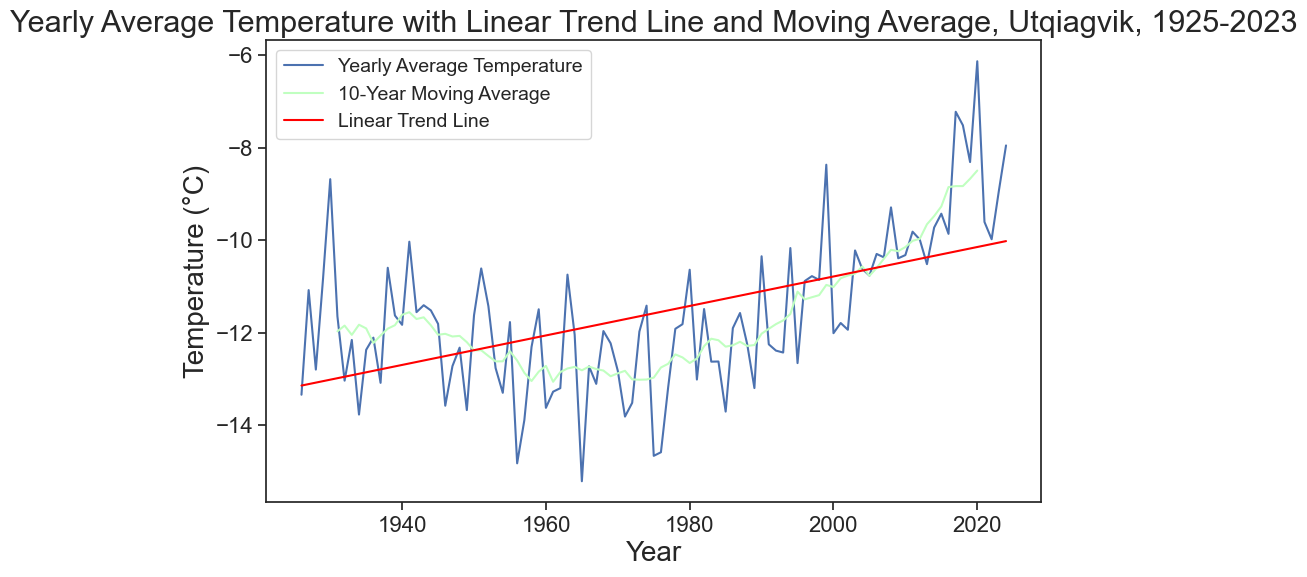

In [8]:
#lets plot yearly temperature data with linear trend line and moving average
plt.figure(figsize=(8, 5))

X = np.arange(len(df_temp)).reshape(-1, 1)
y = df_temp.values
model = LinearRegression()
model.fit(X, y)
trend_Temp = model.predict(X)

window_size = 10
moving_avg = df_temp.rolling(window=window_size, center=True).mean()

plt.figure(figsize=(10, 6))
plt.plot(df_temp.index, df_temp, label='Yearly Average Temperature')
plt.plot(moving_avg.index, moving_avg, label=f'{window_size}-Year Moving Average', color='#C0FFC0')
plt.plot(df_temp.index, trend_Temp, label='Linear Trend Line', color='red')
plt.xlabel('Year', fontsize=20)
plt.ylabel('Temperature (°C)', fontsize=20)
plt.title('Yearly Average Temperature with Linear Trend Line and Moving Average, Utqiagvik, 1925-2023', fontsize=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)
plt.show()

In [9]:
#what is the difference between the start of the linear trend line and the end of the linear trend line?
print("trend line start value is:", trend_Temp[0].round(2))
print("trend line end value is:", trend_Temp[-1].round(2))
print("trend line difference is:", (trend_Temp[-1] - trend_Temp[0]).round(2))
print("trend line percentage change is:", ((trend_Temp[-1] - trend_Temp[0]) / trend_Temp[0] * 100).round(2))
print("trend line percentage change per year is:", ((trend_Temp[-1] - trend_Temp[0]) / trend_Temp[0] * 100 / len(trend_Temp)).round(2))

trend line start value is: -13.14
trend line end value is: -10.02
trend line difference is: 3.12
trend line percentage change is: -23.74
trend line percentage change per year is: -0.24


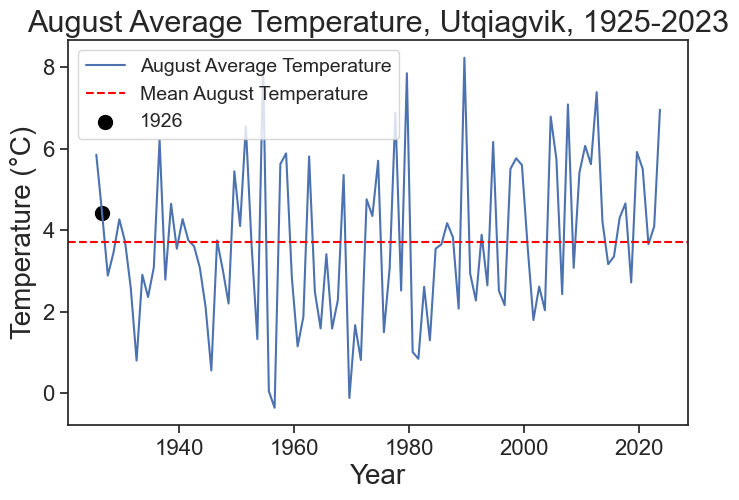

In [10]:
#lets plot the temperature of august the mean and 1926 marked
plt.figure(figsize=(8, 5))
plt.plot(df_aug.index, df_aug['TAVG'], label='August Average Temperature')
plt.axhline(y=df_aug['TAVG'].mean(), color='red', linestyle='--', label='Mean August Temperature')
plt.xlabel('Year', fontsize=20)
plt.ylabel('Temperature (°C)', fontsize=20)
plt.title('August Average Temperature, Utqiagvik, 1925-2023', fontsize=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.scatter(df_aug.index[1], df_aug['TAVG'].loc['1926'], color='black', s=100, label='1926')
plt.legend(fontsize=14)
plt.show()

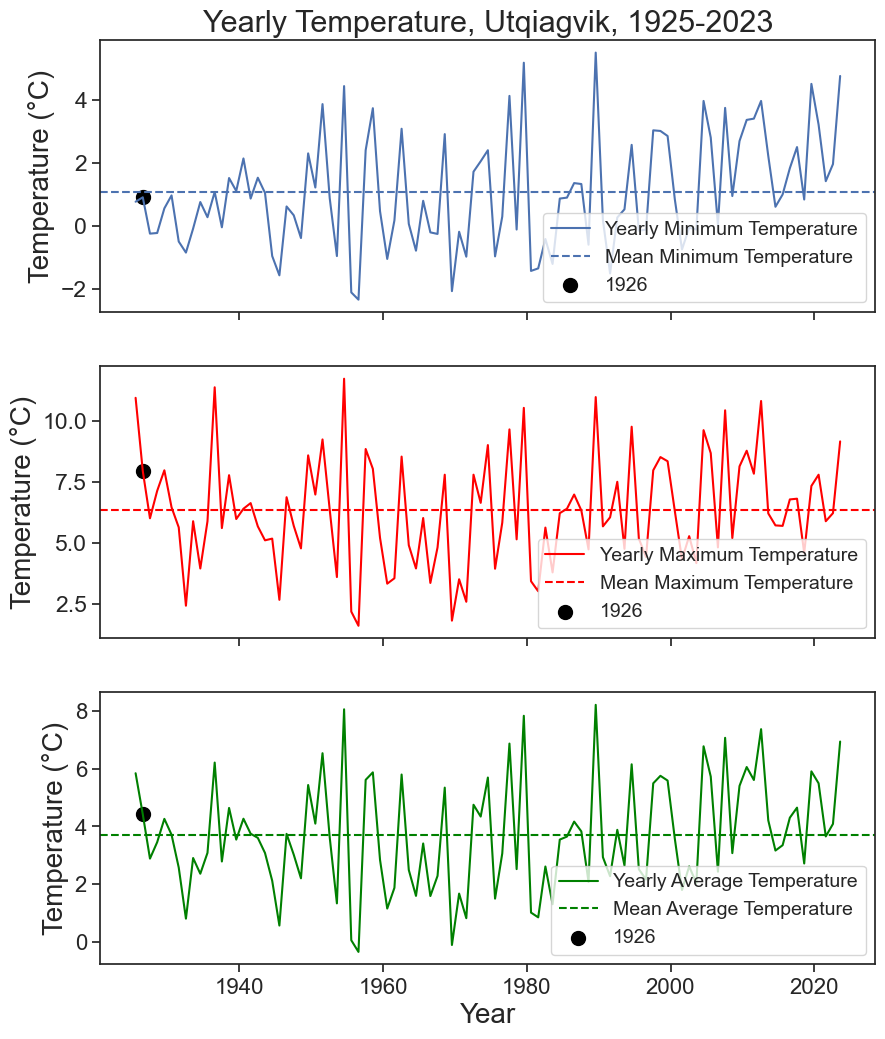

In [11]:
#lets plot 3 graphs the same as above, one for TMIN, one for TMAX and one for TAVG all in one figure with 3 axes
fig, ax = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
ax[0].plot(df_aug.index, df_aug['TMIN'], label='Yearly Minimum Temperature')
ax[1].plot(df_aug.index, df_aug['TMAX'], label='Yearly Maximum Temperature', color='red')
ax[2].plot(df_aug.index, df_aug['TAVG'], label='Yearly Average Temperature', color='green')

ax[0].set_ylabel('Temperature (°C)', fontsize=20)
ax[1].set_ylabel('Temperature (°C)', fontsize=20)
ax[2].set_ylabel('Temperature (°C)', fontsize=20)

ax[0].axhline(y=df_aug['TMIN'].mean(), linestyle='--', label='Mean Minimum Temperature')
ax[1].axhline(y=df_aug['TMAX'].mean(), color='red', linestyle='--', label='Mean Maximum Temperature')
ax[2].axhline(y=df_aug['TAVG'].mean(), color='green', linestyle='--', label='Mean Average Temperature')

ax[0].scatter(df_aug.index[1], df_aug['TMIN'].loc['1926'], color='black', s=100, label='1926')
ax[1].scatter(df_aug.index[1], df_aug['TMAX'].loc['1926'], color='black', s=100, label='1926')
ax[2].scatter(df_aug.index[1], df_aug['TAVG'].loc['1926'], color='black', s=100, label='1926')

ax[0].legend(loc='lower right', fontsize=14)
ax[1].legend(loc='lower right', fontsize=14)
ax[2].legend(loc='lower right', fontsize=14)

ax[2].set_xlabel('Year', fontsize=20)
ax[0].set_title('Yearly Temperature, Utqiagvik, 1925-2023', fontsize=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

# Precipitation Analysis

## Inter-annual variability

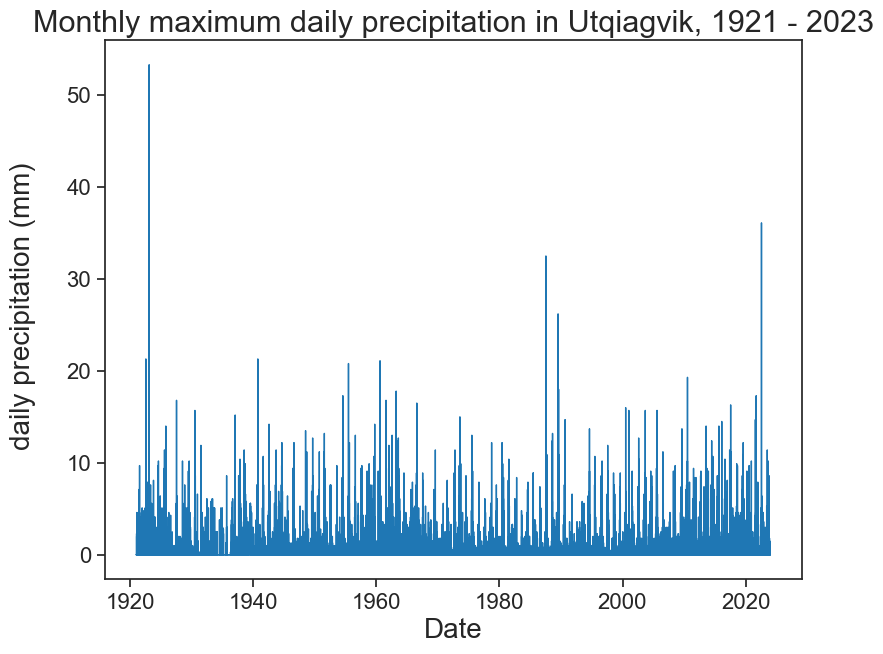

In [12]:
#lets plot the monthly maximum daily precipitation in Utqiagvik plot
fig,ax = plt.subplots(figsize=(9,7))

ax.fill_between(df.index, df['PRCP'], 0, color='tab:blue')
ax.set_title("Monthly maximum daily precipitation in Utqiagvik, 1921 - 2023", fontsize=22)
ax.tick_params(axis='x')
ax.set_xlabel("Date", fontsize=20)
fig.supylabel('daily precipitation (mm)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

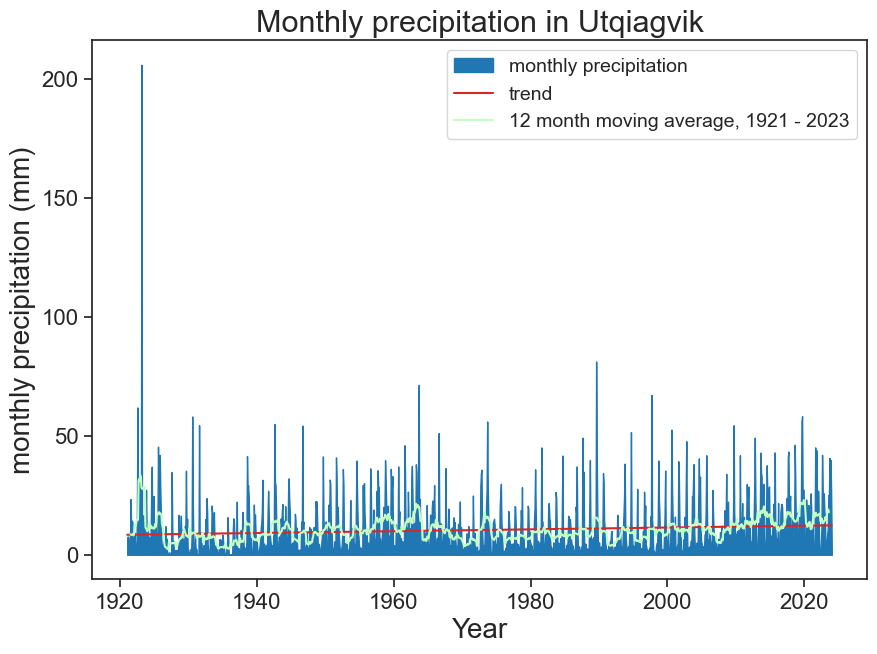

In [13]:
#lets plot monthly sum of precipitation
monthly = df.resample('M').sum()
fig,ax = plt.subplots(figsize=(10,7))

ax.fill_between(monthly.index, monthly['PRCP'], 0, color='tab:blue', label='monthly precipitation')
ax.set_title("Monthly precipitation in Utqiagvik", fontsize=22)
ax.tick_params(axis='x')
ax.set_xlabel("Year", fontsize=20)
ax.set_ylabel("monthly precipitation (mm)", fontsize=20)

x = np.arange(len(monthly))
y = monthly['PRCP']
p = np.polyfit(x, y, 1)
trend_monthly = np.polyval(p, x)
ax.plot(monthly.index, trend_monthly, color='tab:red', label='trend')

window = 12
ma = y.rolling(window, center=True).mean()
ax.plot(monthly.index, ma, color='#C0FFC0', label='{} month moving average, 1921 - 2023'.format(window))

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)
plt.show()

In [14]:
#what is the difference between the start of the linear trend line and the end of the linear trend line?
print("trend line start value is:", trend_monthly[0].round(2), 'mm')
print("trend line end value is:", trend_monthly[-1].round(2), 'mm')
print("trend line difference is:", (trend_monthly[-1] - trend_monthly[0]).round(2), 'mm')
print("trend line percentage change is:", ((trend_monthly[-1] - trend_monthly[0]) / trend_monthly[0] * 100).round(2), '%')
print("trend line percentage change per year is:", ((trend_monthly[-1] - trend_monthly[0]) / trend_monthly[0] * 100 / len(trend_monthly) * 12).round(2), '%')

trend line start value is: 8.41 mm
trend line end value is: 12.35 mm
trend line difference is: 3.94 mm
trend line percentage change is: 46.81 %
trend line percentage change per year is: 0.45 %


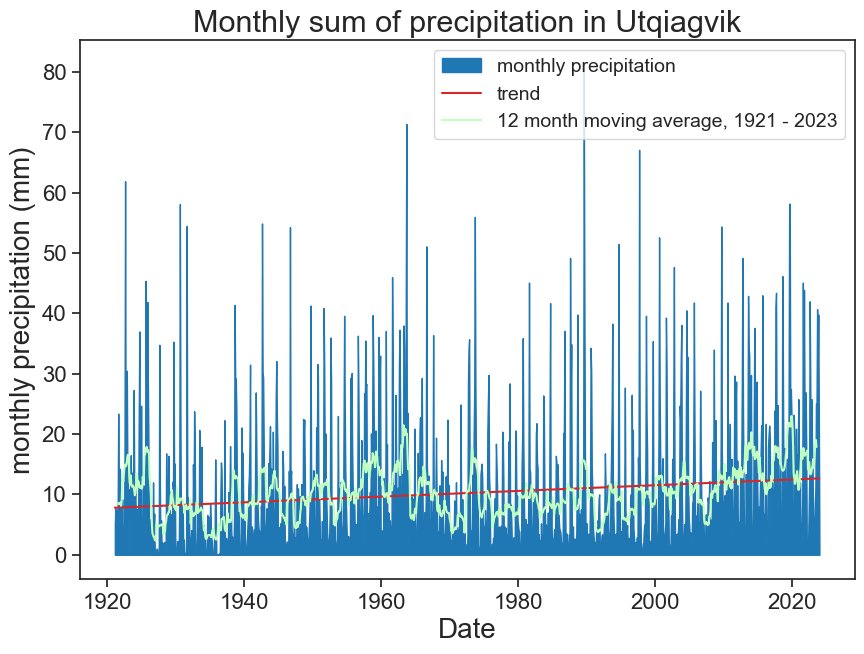

In [15]:
#lets ecxlude the 200 mm month as it is an outlier
monthly = monthly[monthly['PRCP'] < 200]
fig,ax = plt.subplots(figsize=(10,7))

ax.fill_between(monthly.index, monthly['PRCP'], 0, color='tab:blue', label='monthly precipitation')
ax.set_title("Monthly sum of precipitation in Utqiagvik", fontsize=22)
ax.tick_params(axis='x')
ax.set_xlabel("Date", fontsize=20)
ax.set_ylabel("monthly precipitation (mm)", fontsize=20)

x = np.arange(len(monthly))
y = monthly['PRCP']
p = np.polyfit(x, y, 1)
trend_monthly2 = np.polyval(p, x)
ax.plot(monthly.index, trend_monthly2, color='tab:red', label='trend')

window = 12
ma = y.rolling(window, center=True).mean()
ax.plot(monthly.index, ma, color='#C0FFC0', label='{} month moving average, 1921 - 2023'.format(window))

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)
plt.show()

In [16]:
#what is the difference between the start of the linear trend line and the end of the linear trend line?
print("trend line start value is:", trend_monthly2[0].round(2), 'mm')
print("trend line end value is:", trend_monthly2[-1].round(2), 'mm')
print("trend line difference is:", (trend_monthly2[-1] - trend_monthly2[0]).round(2), 'mm')
print("trend line percentage change is:", ((trend_monthly2[-1] - trend_monthly2[0]) / trend_monthly2[0] * 100).round(2), '%')
print("trend line percentage change per year is:", ((trend_monthly2[-1] - trend_monthly2[0]) / trend_monthly2[0] * 100 / len(trend_monthly2) * 12).round(2), '%')

trend line start value is: 7.8 mm
trend line end value is: 12.65 mm
trend line difference is: 4.86 mm
trend line percentage change is: 62.29 %
trend line percentage change per year is: 0.61 %


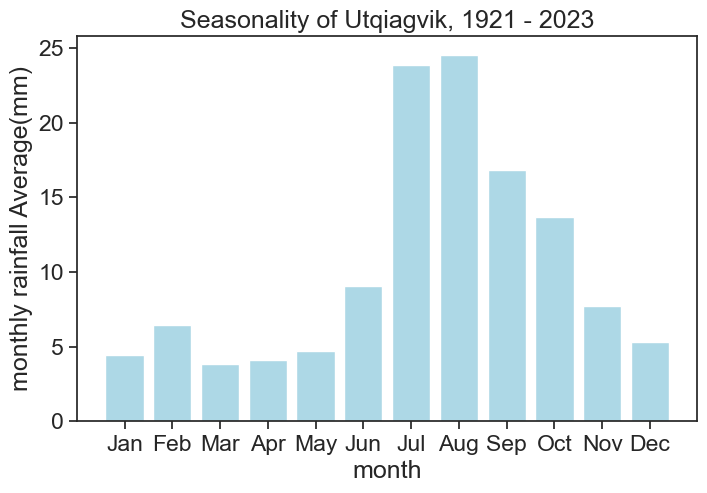

In [17]:
#Seasonality of precipitation in Utqiagvik
df_month = df['PRCP'].resample('M').sum().to_frame()
df_month_avg = (df_month['PRCP']
                  .groupby(df_month.index.month)
                  .mean()
                  .to_frame()
               )
df_month_avg['PRCP'] = pd.to_numeric(df_month_avg['PRCP'], errors='coerce')
df_month_avg.index.names = ['Month']
month_index = ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep',"Oct","Nov","Dec")

fig, ax = plt.subplots(figsize=(8,5))
ax.bar(df_month_avg.index, df_month_avg['PRCP'], color="#ADD8E6", label="Utqiagvik, 1921 - 2023")
ax.set(xlabel="month",
       ylabel="monthly rainfall Average(mm)",
       title='Seasonality of Utqiagvik, 1921 - 2023',
       xticks=np.arange(1,13));

ax.set_xticks(df_month_avg.index)
ax.set_xticklabels(month_index)
plt.show()

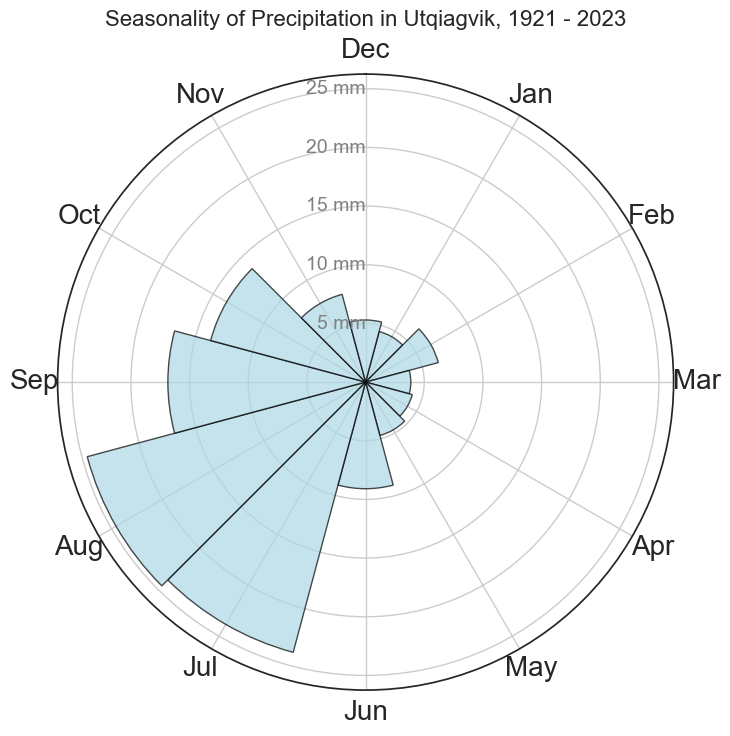

In [18]:
#lets plot the same data in a polar plot
angles = np.linspace(0, 2 * np.pi, len(df_month_avg), endpoint=False).tolist()
angles += angles[:1]  # Complete the circle
precipitation = df_month_avg['PRCP'].tolist()
precipitation += precipitation[:1]  # Complete the circle

angles = [(angle + np.pi/6) % (2 * np.pi) for angle in angles]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

bars = ax.bar(angles[:-1], precipitation[:-1], width=2 * np.pi / len(df_month_avg), color='#ADD8E6', edgecolor='black', alpha=0.7)

ax.set_theta_zero_location('N')  # Sets 0 degrees to the top (North)
ax.set_theta_direction(-1)  # Sets the direction to be counterclockwise

ax.set_xticks(angles[:-1])  # Set the month labels on the x-axis
ax.set_xticklabels(month_index, fontsize=20)  # Set the labels to be month names

ax.set_yticklabels([])  # Remove radial labels
ax.set_title('Seasonality of Precipitation in Utqiagvik, 1921 - 2023', va='bottom', fontsize=16)

for radius in [5, 10, 15, 20, 25]:
    ax.plot([0, 2 * np.pi], [radius, radius], color='grey', linestyle='--', linewidth=0.8)
    ax.text(0, radius, f'{radius} mm', color='grey', fontsize=14, va='center', ha='right')

plt.show()


In [19]:
#lets claculate the seasonality index
def walsh_index(df):
    m = df["PRCP"].values
    R = m.sum()
    SI = np.sum(np.abs(m-R/12)) / R
    return SI

seasonality_index = walsh_index(df_month_avg)
print("Seasonality index (Walsh and Lawler, 1981)")
print(f"Utqiagvik: {seasonality_index:.2f}")

Seasonality index (Walsh and Lawler, 1981)
Utqiagvik: 0.60


In [20]:
df_monthly = pd.read_csv("Utqiagvik_monthly.csv",
                         sep=",",
                         parse_dates=['DATE'],
                         index_col='DATE'
                        )


monthly = (df_monthly['PRCP']
                    .groupby(df_monthly.index.month)
                    .mean()
                    .to_frame()
)
monthly.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly.index.names = ['Month']
monthly['PRCP'] = pd.to_numeric(monthly['PRCP'], errors='coerce')
monthly = monthly.round(2)
months = monthly.index  # Save the original months before converting to NumPy array
total = np.sum(monthly)

# Calculate the shaded area
shaded = monthly - total/12

# Convert to NumPy arrays
shaded = shaded.values.flatten()
monthly = monthly.values.flatten()

c:\Users\gilif\anaconda3\envs\asgard\Lib\site-packages\matplotlib\text.py:758: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
c:\Users\gilif\anaconda3\envs\asgard\Lib\site-packages\matplotlib\text.py:898: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


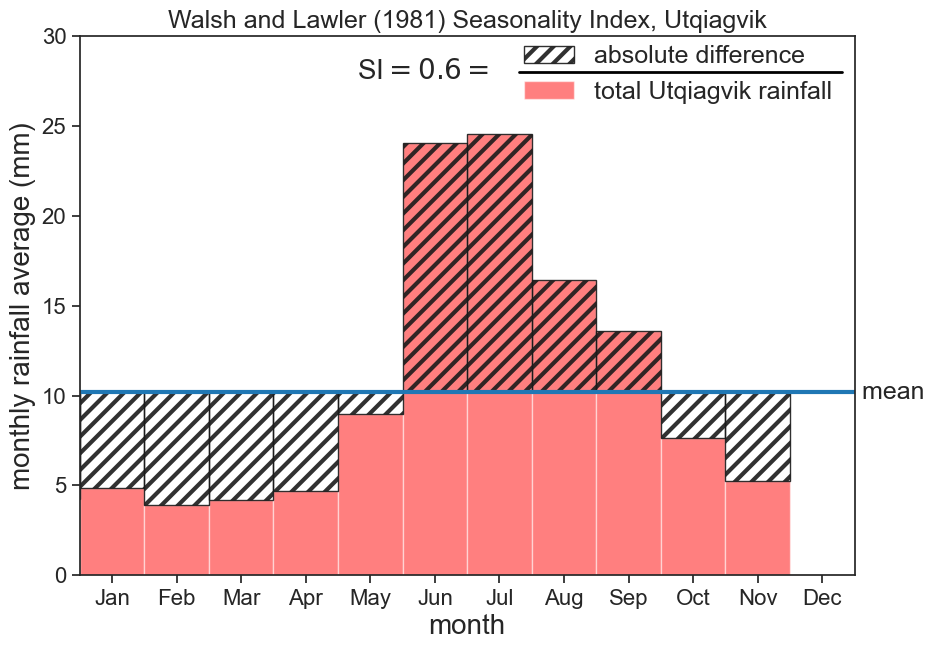

In [21]:
fig, ax = plt.subplots(figsize=(10, 7))

plt.rcParams['hatch.linewidth'] = 3
xlim = [1, 13]
ax.plot(xlim, [total/12]*2, color="tab:blue", linewidth=3) 
ax.set_xlim(xlim)

# Bar plot for the absolute difference
ax.bar(months, shaded,
       alpha=0.9, color="None", width=1,
       hatch="//", edgecolor='k',
       align='edge', bottom=total/12,
       label="absolute difference")  # Ensure label is defined

# Bar plot for the total rainfall
ax.bar(months, monthly,
       alpha=0.5, color="red", width=1,
       align='edge',
       label="total Utqiagvik rainfall", zorder=0)  # Ensure label is defined

# Annotations
ax.text(5.3, 27.6, r"SI$=0.6=$", fontsize=20)
ax.text(xlim[-1], total/12, " mean", va="center")
ax.plot([7.8, 12.8], [28]*2, color="black", lw=2)

ax.set(
       title='Walsh and Lawler (1981) Seasonality Index, Utqiagvik',
       xticks=np.arange(1.5, 12.6, 1),
       xticklabels=months,
       ylim=[0, 30])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_ylabel('monthly rainfall average (mm)', fontsize=20)
ax.set_xlabel('month', fontsize=20)
plt.legend(loc='upper right', frameon=False,bbox_to_anchor=(1, 1.025), fontsize=18)
plt.show()

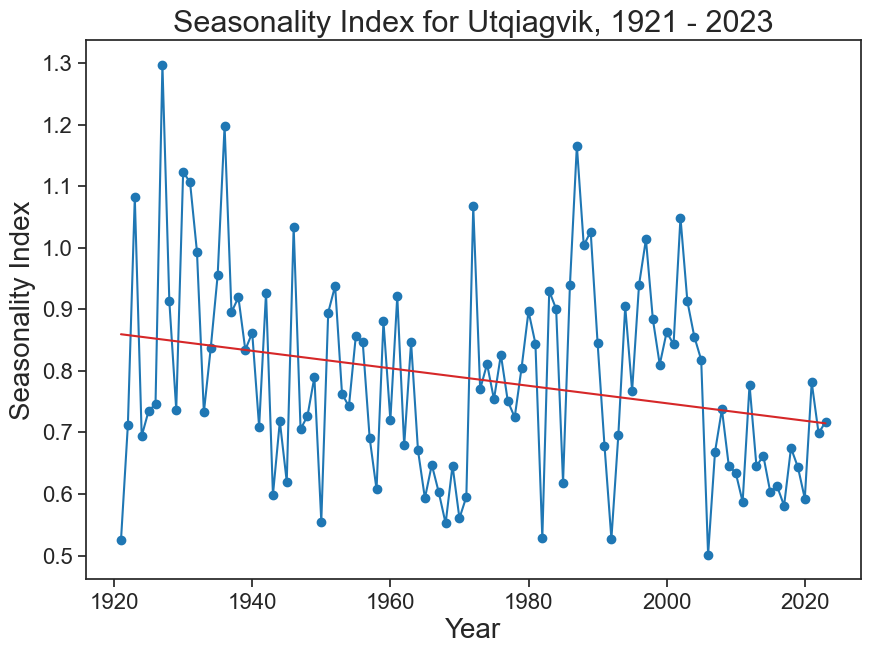

In [22]:
#lets make a function that calculates the seasonality index for a given year
def si_per_year(df,year):
    df_year = df.loc[str(year)]
    df_month = df_year['PRCP'].resample('M').sum().to_frame()
    df_month_avg = (df_month['PRCP']
                      .groupby(df_month.index.month)
                      .mean()
                      .to_frame()
                   )
    df_month_avg['PRCP'] = pd.to_numeric(df_month_avg['PRCP'], errors='coerce')
    df_month_avg.index.names = ['Month']
    return walsh_index(df_month_avg)

years = df.index.year.unique()
si = []
for year in years:
    si.append(si_per_year(df,year))
df_si = pd.DataFrame(si, index=years, columns=['SI'])

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(df_si.index, df_si['SI'], color='tab:blue', marker='o', linestyle='-')
ax.set_title("Seasonality Index for Utqiagvik, 1921 - 2023", fontsize=22)
ax.set_xlabel("Year", fontsize=20)
ax.set_ylabel("Seasonality Index", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
x = np.arange(len(df_si))
y = df_si['SI']
p = np.polyfit(x, y, 1)
trend = np.polyval(p, x)
ax.plot(df_si.index, trend, color='tab:red', label='trend')
plt.show()

In [23]:
#what is the difference between the start of the linear trend line and the end of the linear trend line?
print("trend line start value is:", trend[0].round(2))
print("trend line end value is:", trend[-1].round(2))
print("trend line difference is:", (trend[-1] - trend[0]).round(2))
print("trend line percentage change is:", ((trend[-1] - trend[0]) / trend[0] * 100).round(2))
print("trend line percentage change per year is:", ((trend[-1] - trend[0]) / trend[0] * 100 / len(trend)).round(2))
print("the mean seasonality index is:", df_si['SI'].mean().round(2))

trend line start value is: 0.86
trend line end value is: 0.71
trend line difference is: -0.14
trend line percentage change is: -16.84
trend line percentage change per year is: -0.16
the mean seasonality index is: 0.79


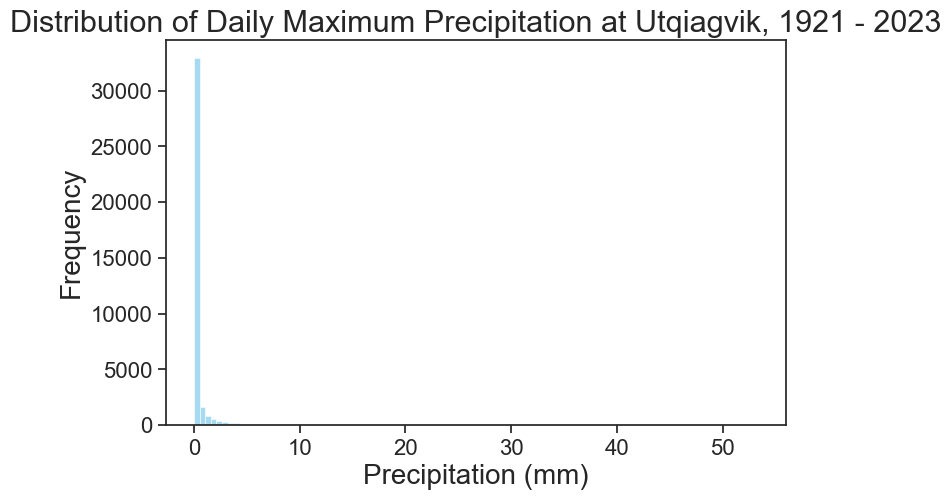

In [24]:
#lets see the distribution of the data
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(df['PRCP'], bins=100, color="skyblue", ax=ax)
ax.set_xlabel('Precipitation (mm)', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)
ax.set_title('Distribution of Daily Maximum Precipitation at Utqiagvik, 1921 - 2023', fontsize=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

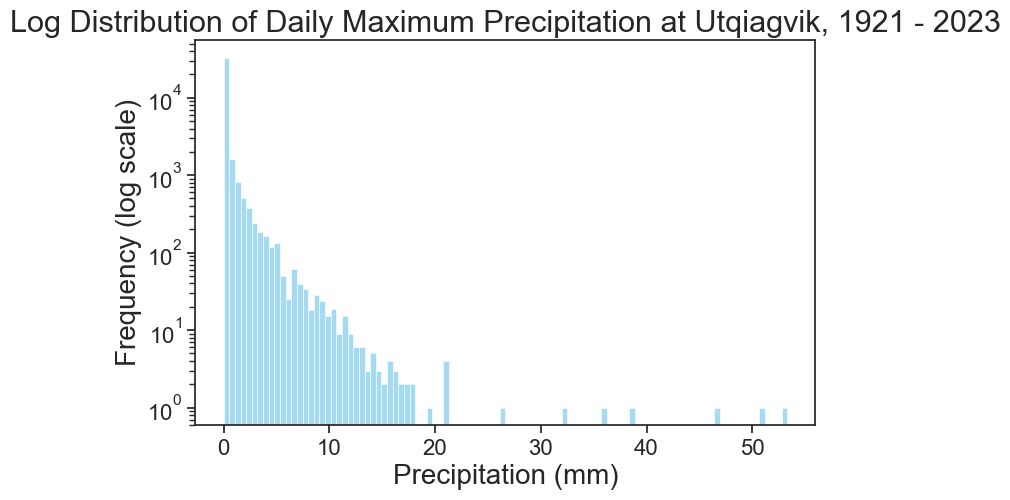

In [25]:
#lets log transform the frequency
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(df['PRCP'], bins=100, color="skyblue", ax=ax, log_scale=(False, True))
ax.set_xlabel('Precipitation (mm)', fontsize=20)
ax.set_ylabel('Frequency (log scale)', fontsize=20)
ax.set_title('Log Distribution of Daily Maximum Precipitation at Utqiagvik, 1921 - 2023', fontsize=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

[Text(0.5, 0, 'annual daily precipitation maxima (mm)'), Text(0, 0.5, 'cdf')]

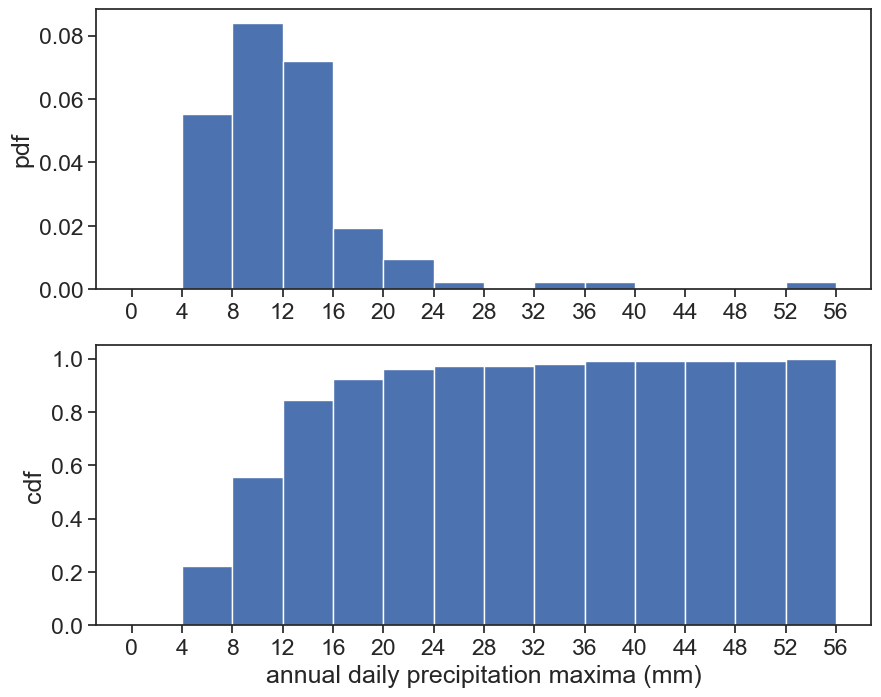

In [26]:
#lets plot the cumulative distribution function and the probability density function
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))
max_annual = (df['PRCP'].resample('A-JUL')
                        .max()
                        .to_frame()
             )
max_annual
h=max_annual['PRCP'].values
ax1.hist(h, bins=np.arange(0,60,4), density=True)
ax2.hist(h, bins=np.arange(0,60,4), cumulative=1, density=True)

ax1.set_xticks(np.arange(0, 60, 4))
ax2.set_xticks(np.arange(0, 60, 4))



ax1.set(ylabel="pdf")
ax2.set(xlabel="annual daily precipitation maxima (mm)",
        ylabel="cdf",
        )


In [27]:
# sort the annual daily precipitation maxima, from lowest to highest
max_annual['max_sorted'] = np.sort(max_annual['PRCP'])
# let's give it a name, h
h = max_annual['max_sorted'].values
# make an array "order" of size N=len(h), from 1 to N
N = len(h)
rank = np.arange(N) + 1
# make a new array, "rank"
cdf_weibull = rank / (N+1)

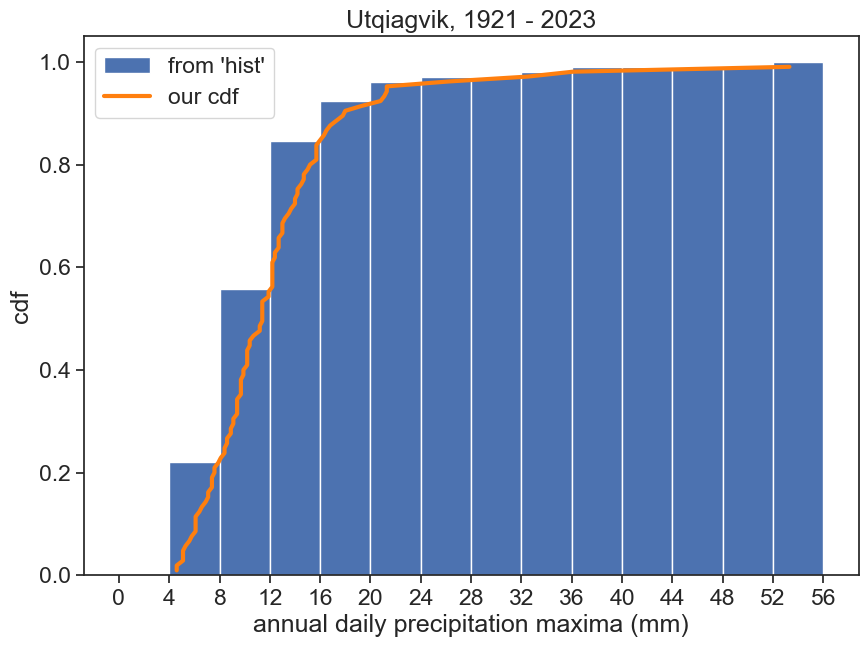

In [28]:
fig, ax = plt.subplots(figsize=(10,7))
ax.hist(h, bins=np.arange(0,60,4), cumulative=1, density=True, label="from 'hist'")
ax.plot(h, cdf_weibull, color="tab:orange", linewidth=3, label="our cdf")
ax.set_ylabel("cdf")
ax.set_xlabel("annual daily precipitation maxima (mm)")
ax.set_title("Utqiagvik, 1921 - 2023")
ax.set_xticks(np.arange(0, 60, 4))
ax.legend()

In [29]:
params = genextreme.fit(h)
print("Best fit:")
print(f"shape = {params[0]:.2f}\nlocation = {params[1]:.2f}\nscale = {params[2]:.2f}")

Best fit:
shape = -0.16
location = 9.41
scale = 3.70


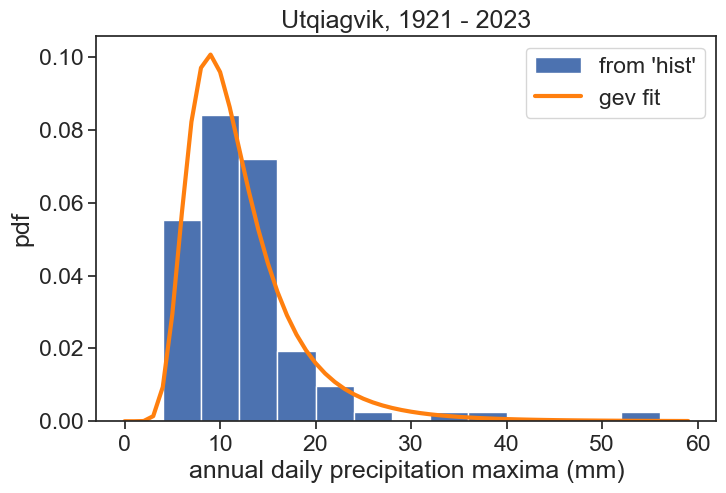

In [30]:
fig, ax = plt.subplots(figsize=(8,5))
ax.hist(h, bins=np.arange(0,60,4), density=True, label="from 'hist'")
rain = np.arange(0,60)
pdf_rain = genextreme(c=params[0], loc=params[1], scale=params[2]).pdf(rain)
ax.plot(rain, pdf_rain, color="tab:orange", lw=3, label="gev fit")
ax.set_ylabel("pdf")
ax.set_xlabel("annual daily precipitation maxima (mm)")
ax.set_title("Utqiagvik, 1921 - 2023")
ax.legend()

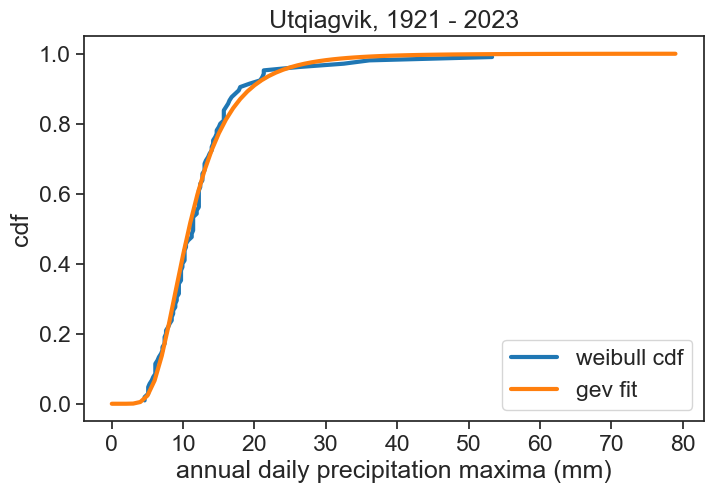

In [31]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(h, cdf_weibull, color="tab:blue", linewidth=3, label="weibull cdf")
rain = np.arange(0,80)
cdf_rain = genextreme(c=params[0], loc=params[1], scale=params[2]).cdf(rain)
ax.plot(rain, cdf_rain, color="tab:orange", lw=3, label="gev fit")
ax.set_ylabel("cdf")
ax.set_xlabel("annual daily precipitation maxima (mm)")
ax.set_title("Utqiagvik, 1921 - 2023")
ax.legend()

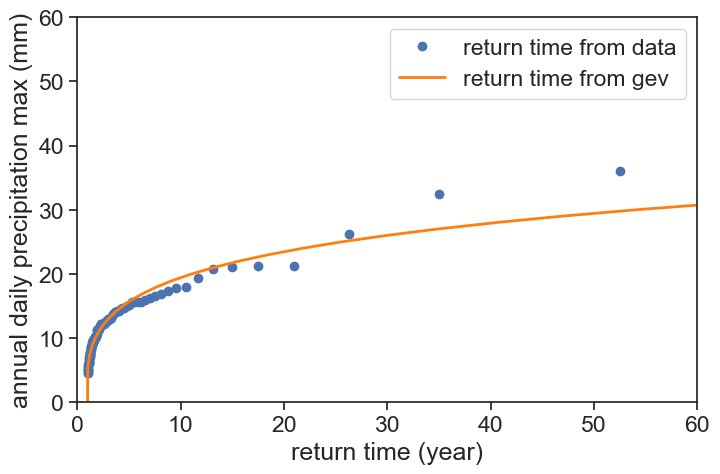

In [32]:
fig, ax = plt.subplots(figsize=(8,5))

T = 1 / (1-cdf_weibull)
ax.plot(T, h, 'o', label="return time from data")

rain = np.arange(0,150)
cdf_rain = genextreme(c=params[0], loc=params[1], scale=params[2]).cdf(rain)

ax.plot(1/(1-cdf_rain), rain, color='tab:orange', lw=2, label="return time from gev")
ax.legend(loc="upper right", frameon=True)
ax.set(xlabel="return time (year)",
       ylabel=f"annual daily precipitation max (mm)",
       xlim=[0, 60],
       ylim=[0, 60]);

In [33]:
# Compute the return levels for several return periods.
return_periods = np.array([5, 10, 20, 50, 100, 500])
return_levels = genextreme.isf(1/return_periods, *params)

print("Return levels:")
print()
print("Period  precipitation")
print("(years)   (mm)")

for period, level in zip(return_periods, return_levels):
    print(f'{period:4.0f}  {level:9.2f}')

Return levels:

Period  precipitation
(years)   (mm)
   5      15.67
  10      19.42
  20      23.47
  50      29.44
 100      34.55
 500      48.77


In [34]:
levels_mm = np.array([10,15, 20, 35, 53.3,100])
return_per = 1/genextreme.sf(levels_mm, *params)

print("Return levels:")
print()
print("precipitation   Period")
print("(mm)       (years)")

for level,period in zip(levels_mm, return_per):
    print(f'{level:9.1f}  {period:4.0f}')

#make a csv file
df_l_r = pd.DataFrame({'precipitation':levels_mm, 'period':return_per})
df_l_r.to_csv('return_levels.csv', index=False)


Return levels:

precipitation   Period
(mm)       (years)
     10.0     2
     15.0     4
     20.0    11
     35.0   106
     53.3   774
    100.0  21010


37588
11


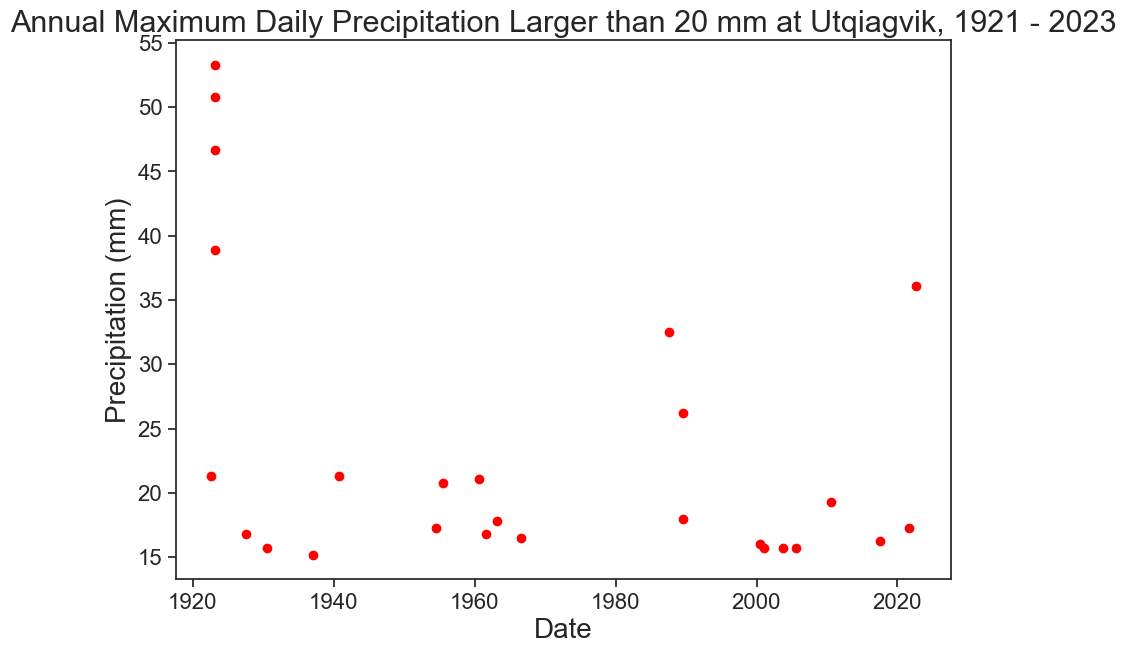

In [35]:
#show me all days that had more than 20 mm of precipitation
print(len(df))
print(len(df[df['PRCP'] > 20]))

df_over_20 = df[df['PRCP'] > 15]
#plot the days with more than 20 mm of precipitation
fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(df_over_20.index, df_over_20['PRCP'], color='red', label='days with more than 20 mm')
ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Precipitation (mm)', fontsize=20)
ax.set_title('Annual Maximum Daily Precipitation Larger than 20 mm at Utqiagvik, 1921 - 2023', fontsize=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

# Evapotranspiration Analysis

## Calculating potential Evapotransporation

In [36]:
#resample the data to daily
df17_resampled = df17[['AIR_TEMPERATURE', 'RELATIVE_HUMIDITY', 'WIND_1_5']].resample('D').mean()
df18_resampled = df18[['AIR_TEMPERATURE', 'RELATIVE_HUMIDITY', 'WIND_1_5']].resample('D').mean()
df19_resampled = df19[['AIR_TEMPERATURE', 'RELATIVE_HUMIDITY', 'WIND_1_5']].resample('D').mean()
df20_resampled = df20[['AIR_TEMPERATURE', 'RELATIVE_HUMIDITY', 'WIND_1_5']].resample('D').mean()
df21_resampled = df21[['AIR_TEMPERATURE', 'RELATIVE_HUMIDITY', 'WIND_1_5']].resample('D').mean()
df22_resampled = df22[['AIR_TEMPERATURE', 'RELATIVE_HUMIDITY', 'WIND_1_5']].resample('D').mean()
df23_resampled = df23[['AIR_TEMPERATURE', 'RELATIVE_HUMIDITY', 'WIND_1_5']].resample('D').mean()

#Concatenate the resampled DataFrames in the specified order
df_TX = pd.concat([df17_resampled, df18_resampled, df19_resampled, df20_resampled, df21_resampled, df22_resampled, df23_resampled])
df_TX

,AIR_TEMPERATURE,RELATIVE_HUMIDITY,WIND_1_5
datetime,,,
2016-12-31,-10.859813,87.224299,3.678131
2017-01-01,-0.953125,90.750000,7.788576
2017-01-02,-4.964236,88.201389,7.495556
2017-01-03,-10.135417,79.461806,8.036250
2017-01-04,-8.450000,85.850694,8.668854
...,...,...,...
2023-12-27,-25.914931,78.329861,1.235556
2023-12-28,-27.040278,75.565972,1.096563
2023-12-29,-25.889931,76.364583,0.316215


In [37]:
#Resample the solar radiation data to daily sums for each DataFrame
X17 = df17['SOLAR_RADIATION'].resample('D').sum()
X18 = df18['SOLAR_RADIATION'].resample('D').sum()
X19 = df19['SOLAR_RADIATION'].resample('D').sum()
X20 = df20['SOLAR_RADIATION'].resample('D').sum()
X21 = df21['SOLAR_RADIATION'].resample('D').sum()
X22 = df22['SOLAR_RADIATION'].resample('D').sum()
X23 = df23['SOLAR_RADIATION'].resample('D').sum()

#Apply the conversion factor to each resampled series
df_TX['SOLAR_RADIATION'] = pd.concat([X17, X18, X19, X20, X21, X22, X23]) * 5 * 60 * 1e-6

In [38]:
elevation = 8.1  # (m) elevation of the station
penm2 = pyet.combination.penman(tmean=df_TX["AIR_TEMPERATURE"],
                                wind=df_TX["WIND_1_5"],
                                elevation=elevation,
                                rh=df_TX["RELATIVE_HUMIDITY"],
                                rn=df_TX["SOLAR_RADIATION"],
                                )

es = pyet.meteo_utils.calc_es(tmean=df_TX["AIR_TEMPERATURE"])
ea = pyet.meteo_utils.calc_ea(tmean=df_TX["AIR_TEMPERATURE"],
                              rh=df_TX["RELATIVE_HUMIDITY"])
vpd = es - ea

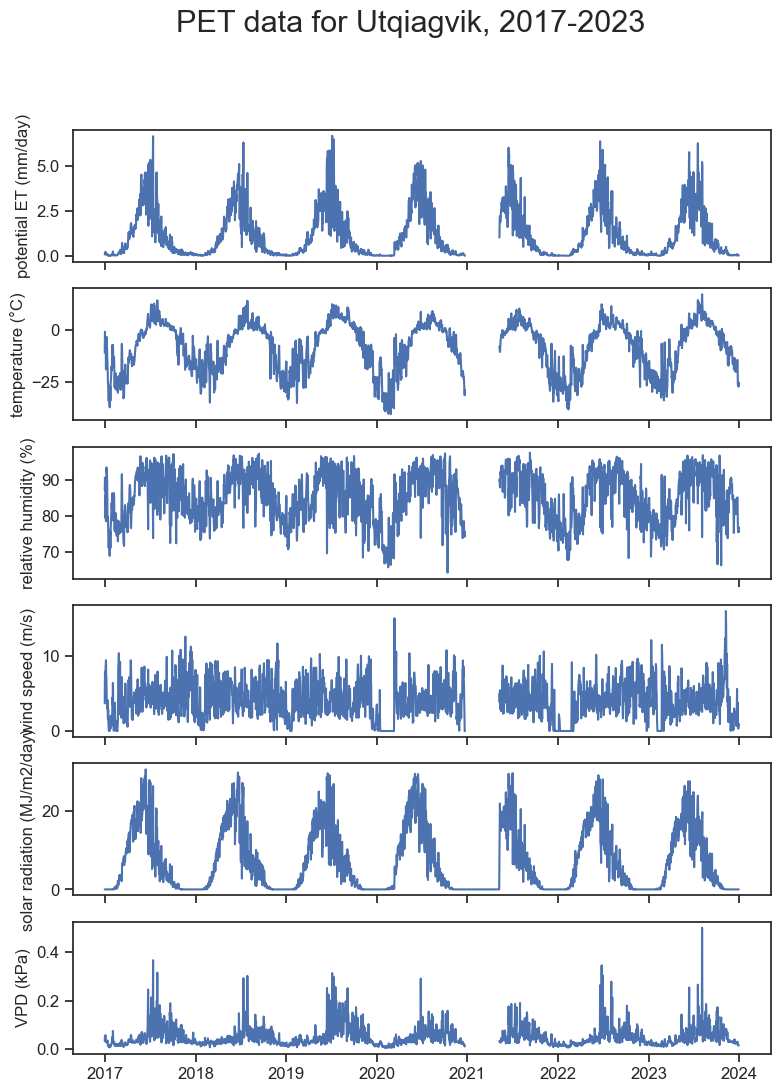

In [44]:
sns.set_theme(style="ticks", font_scale=1.0)
fig, ax = plt.subplots(6,1, figsize=(9,12), sharex=True)
ax[0].plot(penm2); ax[0].set_ylabel("potential ET (mm/day)")
ax[1].plot(df_TX['AIR_TEMPERATURE']); ax[1].set_ylabel("temperature (°C)")
ax[2].plot(df_TX['RELATIVE_HUMIDITY']); ax[2].set_ylabel("relative humidity (%)")
ax[3].plot(df_TX['WIND_1_5']); ax[3].set_ylabel("wind speed (m/s)")
ax[4].plot(df_TX['SOLAR_RADIATION']); ax[4].set_ylabel("solar radiation (MJ/m2/day)")
ax[5].plot(vpd); ax[5].set_ylabel("VPD (kPa)")

fig.suptitle("PET data for Utqiagvik, 2017-2023", fontsize=22)
#fix font size for all axes
for a in ax:
    a.tick_params(labelsize=12)
